# NRC-35: OTE Water Ice Measurements with NIRCam

This activity will use NIRCam longwave grism spectra to check for ice contamination associated with the telescope and instrument cooldown.

## Part 2: Analysis

In [20]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

# Program bar
from tqdm.auto import trange, tqdm

In [21]:
import pynrc
from pynrc import nrc_utils, robust

from pynrc.nrc_utils import webbpsf_ext, webbpsf, poppy, S
from pynrc.nrc_utils import jl_poly, jl_poly_fit
from pynrc.detops import create_detops

from pynrc.reduce.ref_pixels import NRC_refs
from pynrc.reduce.calib import get_fits_data, find_sat, cube_fit
from pynrc.reduce.calib import nircam_cal, bp_fix

pynrc.setup_logging('WARN', verbose=True)

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [22]:
import os

from astropy import units as u
from astropy.io import fits, ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord

# Files

In [23]:
# DMS directory
# indir = '/Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/'
indir = '/home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/'

# Define directory to save figures and output
figdir = os.path.join(indir, 'figures_20220105/')

In [24]:
# Only interested in specific visit
vid = '001:001'

# Search for files with a specific 
visit_files = []
for file in os.listdir(indir):
    if file.startswith("jw") and file.endswith(".fits"):
        fstr = file.split('_')[0][-6:]
        if fstr==''.join(vid.split(':')):
            visit_files.append(os.path.join(indir,file))
            
print(visit_files)

['/home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/jw01409001001_02101_00001_nrca5_uncal.fits', '/home/jarronl/data/NIRData/NRC_Sims/Sim_NRC35/jw01409001001_02101_00002_nrca5_uncal.fits']


In [25]:
def get_model_ice_nvr(file):
    """Get modeled Ice and NVR layers
    
    Assumes a single layer.

    Returns (ice, nvr) layer thickness in units of microns.
    """

    hdul = fits.open(file)
    hdr = hdul[0].header
    hdul.close()

    ice_scale = hdr.get('ICESCALE')
    nvr_scale = hdr.get('NVRSCALE')
    nc_scale  = hdr.get('NCSCALE')
    ote_scale = hdr.get('OTESCALE')

    ice_scale = None if ice_scale == 'NONE' else ice_scale
    nvr_scale = None if nvr_scale == 'NONE' else nvr_scale
    nc_scale  = None if nc_scale  == 'NONE' else nc_scale
    ote_scale = None if ote_scale == 'NONE' else ote_scale

    # ote_scale takes priority over ice_scale
    if ote_scale is not None:
        ice_scale = ote_scale
    # nc_scale turns off nvr_scale
    if nc_scale is not None:
        nvr_scale = 0

    ice_layer = 0
    nvr_layer = 0

    if ice_scale is not None:
        ice_layer += ice_scale * 0.0131
    if nvr_scale is not None:
        nvr_layer += nvr_scale * 0.280
    if nc_scale is not None:
        ice_layer += nc_scale * 0.050
        nvr_layer += nc_scale * 0.189

    return (ice_layer, nvr_layer)

In [26]:
# Get layer thicknesses in Angstroms
ice_thick, nvr_thick = np.array(get_model_ice_nvr(visit_files[0]))*1e4

print(f"Ice Layer = {ice_thick:4.0f} A")
print(f"NVR Layer = {nvr_thick:4.0f} A")

Ice Layer =  316 A
NVR Layer =  945 A


# Verify source positions

In [27]:
def get_slope_image(file, int_ind=None, lincorr=False, fit_deg=2, reffix=True, 
                    sat_vals=None, sat_frac=0.95, **kwargs):
    
        
    hdul = fits.open(file)
    hdr = hdul[0].header
    hdul.close()

    det = create_detops(hdr, DMS=True)
    tarr = det.times_group_avg
    
    # Reference pixel correction keywords
    nbot, ntop, nleft, nright = det.ref_info
    kwargs_def = {
        'nchans': det.nout, 'altcol': True, 'in_place': True,    
        'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False,
        'nbot': nbot, 'ntop': ntop, 'nleft': nleft, 'nright': nright,
    }
    for k in kwargs_def.keys():
        if k not in kwargs:
            kwargs[k] = kwargs_def[k]
            
    # Cycle through each integration
    nint = det.multiaccum.nint
    imarr_slope = []
    if int_ind is None:
        for i in range(nint):
            data = get_fits_data(f, DMS=True, int_ind=i, reffix=reffix, **kwargs)
            cf_arr = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=sat_frac, 
                              deg=fit_deg, ref_info=det.ref_info)
            imarr_slope.append(cf_arr[1])

        imarr_slope = np.asarray(imarr_slope)
        im_slope = np.mean(imarr_slope, axis=0)
    else:
        data = get_fits_data(f, DMS=True, int_ind=int_ind, reffix=reffix, **kwargs)
        cf_arr = cube_fit(tarr, data, sat_vals=sat_vals, sat_frac=sat_frac, 
                          deg=fit_deg, ref_info=det.ref_info)
        im_slope = cf_arr[1]
    
    return im_slope

In [28]:
def do_lincorr(data, det, bias_sub=True, superbias=None, cal_obj=None, cframe='sci', **kwargs):
    """Perform linearity corrections on image or cube"""

    from pynrc.reduce.calib import nircam_cal, apply_linearity
    from pynrc.maths.coords import det_to_sci, sci_to_det

    cal_obj = nircam_cal(det.scaid, verbose=False) if cal_obj is None else cal_obj

    # Convert from sci to det coordinates
    if cframe=='sci':
        data = sci_to_det(data, det.detid)

    # Subtract bias
    if bias_sub:
        ny, nx = (det.ypix, det.xpix)
        x1, x2 = (det.x0, det.x0 + nx)
        y1, y2 = (det.y0, det.y0 + ny)
        superbias = cal_obj.super_bias if superbias is None else superbias
        data -= superbias[y1:y2,x1:x2]
    
    # Apply linearity correction
    data = apply_linearity(data, det, cal_obj.linear_dict)

    # Convert back to sci coordinates if input were sci
    if cframe=='sci':
        data = det_to_sci(data, det.detid)

    return data


def do_flatcorr(data, det, cal_obj=None, pflat_corr=True, lflat_corr=True, cframe='sci'):
    """Perform flat field corrections on image or cube"""
    
    from pynrc.simul.ngNRC import apply_flat
    from pynrc.maths.coords import det_to_sci, sci_to_det
    
    if (not pflat_corr) and (not lflat_corr):
        return data
    
    cal_obj = nircam_cal(det.scaid, verbose=False) if cal_obj is None else cal_obj

    # Convert from sci to det coordinates
    if cframe=='sci':
        data = sci_to_det(data, det.detid)

    # Apply flat field corrections
    if pflat_corr and (cal_obj.pflats is not None):
        data = apply_flat(data, det, 1/cal_obj.pflats)
    if lflat_corr and (cal_obj.lflats is not None):
        data = apply_flat(data, det, 1/cal_obj.lflats)
        
    # Convert back to sci coordinates if input were sci
    if cframe=='sci':
        data = det_to_sci(data, det.detid)

    return data

In [29]:
def get_all_data(file, return_mean=True, mn_func=np.mean, reffix=True, 
                 lin_corr=True, pflat_corr=False, lflat_corr=False, cal_obj=None, **kwargs):
    
    
    hdul = fits.open(file)
    hdr = hdul[0].header
    hdul.close()

    det = create_detops(hdr, DMS=True)
    tarr = det.times_group_avg
    
    # Reference pixel correction keywords
    nbot, ntop, nleft, nright = det.ref_info
    kwargs_def = {
        'nchans': det.nout, 'altcol': True, 'in_place': True,    
        'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False,
        'nbot': nbot, 'ntop': ntop, 'nleft': nleft, 'nright': nright,
    }
    for k in kwargs_def.keys():
        if k not in kwargs:
            kwargs[k] = kwargs_def[k]
            
    # Cycle through each integration
    nint = det.multiaccum.nint
    imarr = []
    for i in trange(nint, desc='Integrations', leave=False):
        data = get_fits_data(file, DMS=True, int_ind=i, reffix=reffix, **kwargs)
        
        # Perform linearity correction?
        if lin_corr:
            if not reffix:
                print('Must perform reference pixel correction with linearity correction.')
            else:
                # Will subtract a superbias stored in cal_obj by default
                data = do_lincorr(data, det, cal_obj=cal_obj, **kwargs)
                
        # Perform flat field corrections (just returns input if _corr keywords are False)
        data = do_flatcorr(data, det, cal_obj=cal_obj, pflat_corr=pflat_corr, lflat_corr=lflat_corr)
            
        imarr.append(data)
    imarr = np.asarray(imarr)
    
    # Return average of all ramps or full array?
    if return_mean:
        return mn_func(imarr, axis=0)
    else:
        return imarr


### Perform data reduction

In [30]:
# Create detector class for this visit
hdul = fits.open(visit_files[0])
hdr = hdul[0].header
hdul.close()

det = create_detops(hdr, DMS=True)

# Reference pixel correction keywords
print(det.ref_info)
nbot, ntop, nleft, nright = det.ref_info
kwargs_ref = {
    'nchans': det.nout, 'altcol': True, 'in_place': True,    
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False,
    'nbot': nbot, 'ntop': ntop, 'nleft': nleft, 'nright': nright,
}

[4 4 4 4]


In [31]:
# Create detector cal object
cal_obj = nircam_cal(det.scaid, verbose=False)

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# Ref pixel correction, linearity correction, averaging...

# On-source data
data_all_on = get_all_data(visit_files[0], return_mean=True, mn_func=np.median, 
                           lin_corr=True, cal_obj=cal_obj, reffix=True, **kwargs_ref)

# Off-source data
data_all_off = get_all_data(visit_files[1], return_mean=True, mn_func=np.median, 
                            lin_corr=True, cal_obj=cal_obj, reffix=True, **kwargs_ref)


Integrations:   0%|          | 0/10 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Integrations:   0%|          | 0/10 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

Linearity:   0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
# Fits slopes
tarr = det.times_group_avg
cf_arr = cube_fit(tarr, data_all_on, sat_vals=det.well_level, sat_frac=0.8, 
                  deg=1, ref_info=det.ref_info)
im_slope = cf_arr[1]

cf_arr = cube_fit(tarr, data_all_off, sat_vals=det.well_level, sat_frac=0.8, 
                  deg=1, ref_info=det.ref_info)
im_slope_bg = cf_arr[1]

In [34]:
# Apply flat field corrections
do_flat_on_slopes = True
do_flat_on_diff   = False

# Ensure that we don't accidentally perform flats twice
if do_flat_on_slopes:
    do_flat_on_diff = False

if do_flat_on_slopes:
    im_slope = do_flatcorr(im_slope, det, cal_obj=cal_obj, pflat_corr=True, lflat_corr=True)
    im_slope_bg = do_flatcorr(im_slope_bg, det, cal_obj=cal_obj, pflat_corr=True, lflat_corr=True)
    
# Take difference
diff = im_slope - im_slope_bg
# Apply flat field corrections?
if do_flat_on_diff:
    diff = do_flatcorr(diff, det, cal_obj=cal_obj, pflat_corr=True, lflat_corr=True)

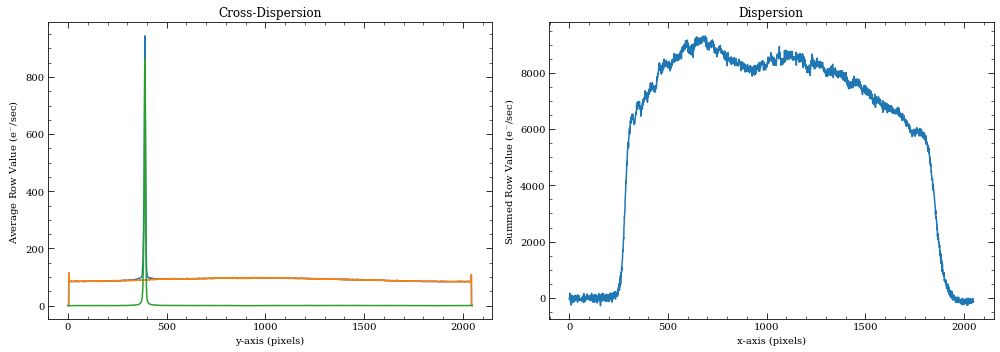

In [35]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

ax = axes[0]
for im in [im_slope, im_slope_bg]:
    ax.plot(np.median(im, axis=1))
    
ax.plot(np.median(diff, axis=1))
    
ax.set_xlabel('y-axis (pixels)')
ax.set_ylabel('Average Row Value (e$^{-}$/sec)')

ax.set_title('Cross-Dispersion')


ax = axes[1]
im = bp_fix(diff, sigclip=10, niter=10, verbose=False, in_place=False)
ax.plot(np.sum(im, axis=0))
    
ax.set_xlabel('x-axis (pixels)')
ax.set_ylabel('Summed Row Value (e$^{-}$/sec)')

ax.set_title('Dispersion')

fig.tight_layout()

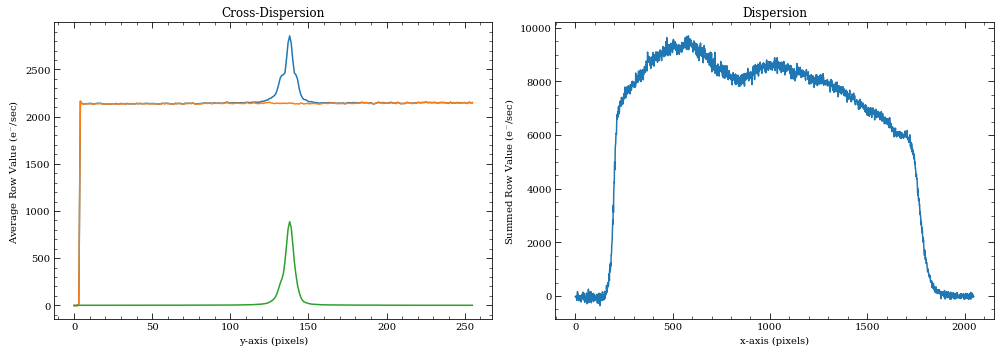

In [16]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

ax = axes[0]
for im in [im_slope, im_slope_bg]:
    ax.plot(np.median(im, axis=1))
    
ax.plot(np.median(diff, axis=1))
    
ax.set_xlabel('y-axis (pixels)')
ax.set_ylabel('Average Row Value (e$^{-}$/sec)')

ax.set_title('Cross-Dispersion')


ax = axes[1]
im = bp_fix(diff, sigclip=10, niter=10, verbose=False, in_place=False)
ax.plot(np.sum(im, axis=0))
    
ax.set_xlabel('x-axis (pixels)')
ax.set_ylabel('Summed Row Value (e$^{-}$/sec)')

ax.set_title('Dispersion')

fig.tight_layout()

## Spectral Extraction

In [36]:
# Perform bad pixel fixing
diff = im_slope - im_slope_bg
# Apply flat field corrections?
if do_flat_on_diff:
    diff = do_flatcorr(diff, det, cal_obj=cal_obj, pflat_corr=True, lflat_corr=True)

diff = bp_fix(diff, sigclip=10, niter=10, verbose=True)

Bad Pixels fixed: 6024
Bad Pixels fixed: 1680
Bad Pixels fixed: 1448
Bad Pixels fixed: 1169
Bad Pixels fixed: 1005
Bad Pixels fixed: 842
Bad Pixels fixed: 711
Bad Pixels fixed: 612
Bad Pixels fixed: 537
Bad Pixels fixed: 470


In [41]:
yind = np.where((ymed>600) & (ymed<1000))[0]
ymed[yind]

array([745.55294982, 809.75437671, 810.57697435, 692.87809596])

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev     
    ----------------- ----------------- -----------------
    771.9315267189144 389.1724058573462 3.378897087707259


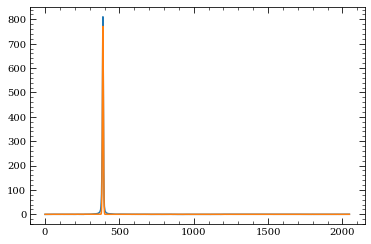

In [42]:
# Get width of Gaussian
from astropy.modeling import models, fitting

ymed = np.median(diff, axis=1)
yvals = np.arange(len(ymed))

yind = np.where((ymed>600) & (ymed<1000))[0]
amp = np.median(ymed[yind])
mn = np.median(yind)

g_init = models.Gaussian1D(amplitude=amp, mean=mn, stddev=5.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, yvals, ymed)

plt.plot(yvals, ymed)
plt.plot(yvals, g(yvals), label='Gaussian')

print(g)

psf_sig_pix = g.stddev.value

In [43]:
# Extract spectrum
# Location
indy = int(g.mean.value + 0.5)
# Extract at 10-sigma
nsig = 15
yext_size = int(nsig * g.stddev.value + 0.5)

# Extraction width varies with wavelength
# Assume each pixel is 0.001 um
dw = diff.shape[1] * 0.001
bp = pynrc.read_filter('F322W2')
wavg = bp.avgwave() / 1e4
wmin, wmax = np.array([-1,1])*dw/2 + wavg
y_ext_min, y_ext_max = yext_size * np.array([wmin, wmax]) / wavg
y_ext_arr = np.linspace(y_ext_min, y_ext_max, diff.shape[1])
# Get y-indices for each column
y1_arr = (indy - y_ext_arr/2).astype('int')
y2_arr = (y1_arr + y_ext_arr).astype('int')

# Create extraction region mask
ind_mask = np.zeros_like(diff).astype('bool')
for i, (y1, y2) in enumerate(zip(y1_arr, y2_arr)):
    ind_mask[y1:y2,i] = True

# Zero out everything outside of region and sum along y-axis
diff2 = diff.copy()
diff2[~ind_mask] = 0
spec_extract = diff2.sum(axis=0)

# y1 = indy - int(yext_size/2)
# y2 = y1 + yext_size
# spec_extract2 = diff[y1:y2,:].sum(axis=0)

# print(indy, yext_size, (y1, y2))

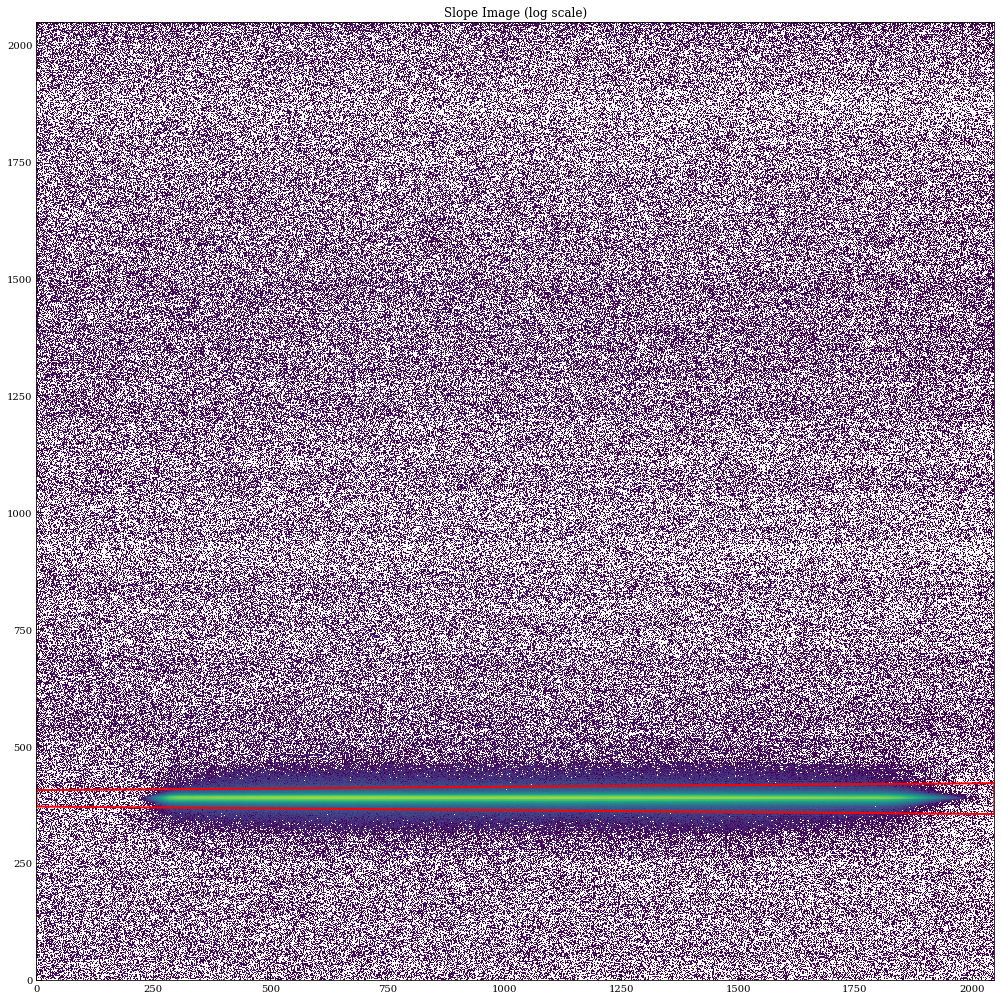

In [45]:
fig, ax = plt.subplots(1,1, figsize=(14,14))

# Plot image
ax.imshow(np.log10(diff), vmin=0, vmax=3.5)
ax.set_title('Slope Image (log scale)')

# Extraction region
from matplotlib.patches import Rectangle, Polygon
# rect = Rectangle((0, y1+1), 2048, y2-y1+1, linewidth=2,edgecolor='r',facecolor='none')
# ax.add_patch(rect)

xy = np.array([[0,y1_arr.max()],[0,y2_arr.min()],[2048,y2_arr.max()],[2048,y1_arr.min()]])
poly = Polygon(xy, linewidth=2,edgecolor='r', facecolor='none')
ax.add_patch(poly)

fig.tight_layout()
# fig.savefig(figdir + 'imspsec.pdf')

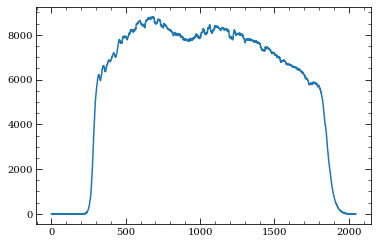

In [46]:
plt.plot(spec_extract)

## Wavelength Calibration

In [47]:
def wcal_model(wmin=2.2, dw=0.001, nel=2048):
    """Create a wavelenght array"""
    
    wmax = wmin + nel*dw
    return np.linspace(wmin, wmax, nel)

def diff_func(params, wmodel, fmodel, fextract):
    """Difference function for least-squares fitting routine"""
    
    wmin, dw, amp1, amp2 = params
    wcal = wcal_model(wmin=wmin, dw=dw)

    ind1 = wcal < 2.5
    ind2 = wcal > 3.9
    ftemp_interp1 = np.interp(wcal[ind1], wmodel, fmodel, left=0, right=0) * amp1
    ftemp_interp2 = np.interp(wcal[ind2], wmodel, fmodel, left=0, right=0) * amp2

    diff = np.zeros_like(wcal)
    diff[ind1] = fextract[ind1] - ftemp_interp1
    diff[ind2] = fextract[ind2] - ftemp_interp2
    return diff

def ideal_spec(filt='F322W2', pupil='GRISMR', spt='G2V', normalize=True, 
               ice_scale=None, nvr_scale=None, ote_scale=0, nc_scale=0, **kwargs):

    from astropy.convolution import Gaussian1DKernel, convolve

    # Create ideal observed spectrum
    bp = pynrc.read_filter(filt, pupil=pupil, ice_scale=ice_scale, nvr_scale=nvr_scale,
                           ote_scale=ote_scale, nc_scale=nc_scale)
    sp = pynrc.stellar_spectrum(spt)

    obs = S.Observation(sp, bp, binset=bp.wave)
    obs.convert('counts')

    wtemp = obs.binwave / 1e4
    ftemp = obs.binflux

    # wavelengths per pixel
    _, dw = nrc_utils.grism_res(pupil=pupil, module='A')
    psf_sig_wave = psf_sig_pix * dw
    # Number of elements to smooth over
    std = psf_sig_wave / np.median(wtemp[1:] - wtemp[:-1])
    
    # Perform Gaussian smoothing and normalize
    g = Gaussian1DKernel(stddev=std)
    ftemp_smth = convolve(ftemp, g)
    
    if normalize:
        return wtemp, ftemp_smth / ftemp_smth.max()
    else:
        return wtemp, ftemp_smth


def get_wparams(spec_extract, filt='F322W2', pupil='GRISMR', pinit=None, **kwargs):
    """Perform wavelength calibraiton"""

    from scipy import optimize

    wtemp, ftemp_norm = ideal_spec(filt=filt, pupil=pupil, **kwargs)
    
    # Average scale factor
    amp_avg = spec_extract.sum() / ftemp_norm.sum()
    
    if pinit is None:
        _, dw = nrc_utils.grism_res(pupil=pupil, module='A')
        pinit = [2.2, dw, amp_avg, amp_avg]

    # Add bounds
    lim_min = [2.1, dw-0.0002, amp_avg/2, amp_avg/2]
    lim_max = [2.3, dw+0.0002, 2*amp_avg, 2*amp_avg]
    bounds = (lim_min, lim_max)
    
    # Perform least squares fitting
    args = (wtemp, ftemp_norm, spec_extract)
    res = optimize.least_squares(diff_func, pinit, args=args, bounds=bounds)
    
    return res.x

In [54]:
# Determine wavelength array

spt = 'G5V'
kwargs = {'filt': 'F322W2', 'pupil': 'GRISMR', 'spt': spt, 'normalize': True}

# Get best-fit
params = get_wparams(spec_extract, **kwargs)

# Wavelength array
wmin, dw, amp1, amp2 = params
wave_extract = wcal_model(wmin=wmin, dw=dw, nel=len(spec_extract))

# Ideal spectrum for plotting
wtemp, ftemp_norm = ideal_spec(**kwargs)

2.1509077222356243 0.0010035351042040018


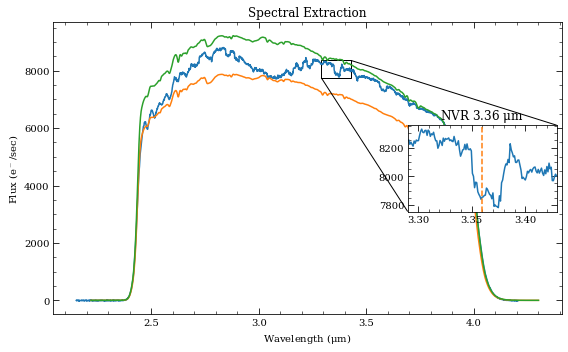

In [55]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
# str_um = '$\mu \mathrm{m}$'
str_um = '$\mathdefault{\mu m}$'

fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(wave_extract, spec_extract)
ax.plot(wtemp, ftemp_norm*amp1)
ax.plot(wtemp, ftemp_norm*amp2)

ax.set_title('Spectral Extraction')
ax.set_xlabel('Wavelength ({})'.format(str_um))
ax.set_ylabel('Flux (e$^-$/sec)')

# Inset axes
axins = zoomed_inset_axes(ax, 5, loc='center right') # zoom-factor: 2.5
mark_inset(ax, axins, 3, 1)#, fc="none", ec="0.5")
axins.set_title('NVR 3.36 {}'.format(str_um))
ind = (wave_extract>3.36-0.07) & (wave_extract<3.36+0.07)
axins.plot(wave_extract[ind], spec_extract[ind])
xlim = [wave_extract[ind].min(), wave_extract[ind].max()]
ylim = axins.get_ylim()
xind = 3.36
axins.plot([xind,xind], ylim, ls='--')
axins.set_ylim(ylim)
axins.set_xlim(xlim)

fig.tight_layout()

print(wmin, dw)

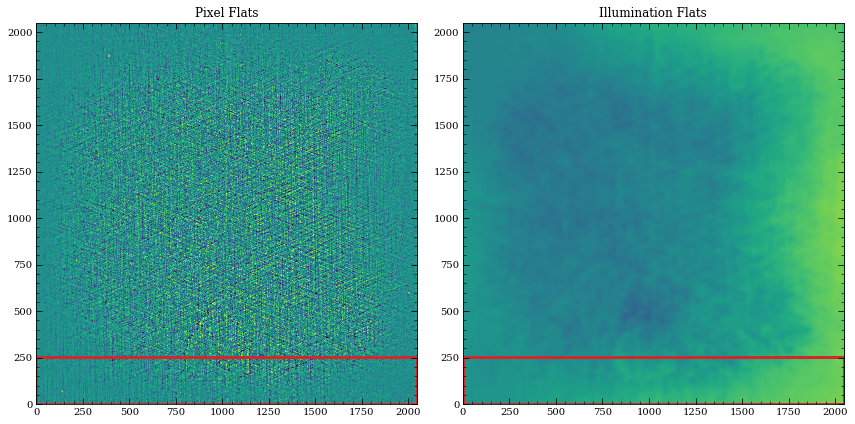

In [25]:
# Plot flat field structures

from matplotlib.patches import Rectangle, Polygon
fig, axes = plt.subplots(1,2, figsize=(12,6))

for i, im in enumerate([cal_obj.pflats, cal_obj.lflats]):
    ax = axes[i]
    mn = np.median(im)
    std = robust.medabsdev(im)
    vmin, vmax = 5 * std * np.array([-1,1]) + mn
    
    rect = Rectangle((0,0), 2048, 256, linewidth=3, edgecolor='C3', facecolor='none')
    ax.add_patch(rect)

    
    ax.imshow(im, vmin=vmin, vmax=vmax)
    if i==0:
        ax.set_title('Pixel Flats')
    else:
        ax.set_title('Illumination Flats')

    
        
fig.tight_layout()

## Ice and NVR absorption models

In [56]:
def nc_eol_model(ice_thick=0.05, nvr_thick=0.189, wave=None):
    """Default NIRCam model for End of Life"""
    path = webbpsf_ext.__path__[0]

    fname = os.path.join(path, 'throughputs/h2o_abs.txt')
    names = ['Wave', 'coeff'] # coeff is per um path length
    data_ice  = ascii.read(fname, names=names)

    fname = os.path.join(path, 'throughputs/nvr_abs.txt')
    names = ['Wave', 'coeff'] # coeff is per um path length
    data_nvr  = ascii.read(fname, names=names)
    
    w_ice = data_ice['Wave']
    a_ice = data_ice['coeff']

    w_nvr = data_nvr['Wave']
    a_nvr = data_nvr['coeff']
    
    # Regrid to common wavelength
    if wave is None:
        wave = w_nvr
    else:
        a_nvr = np.interp(wave, w_nvr, a_nvr)
    a_ice = np.interp(wave, w_ice, a_ice)

    t_ice = np.exp(-a_ice*ice_thick)
    t_nvr = np.exp(-a_nvr*nvr_thick)
    t_nc = t_ice * t_nvr
    
    t_nc = np.exp(-a_ice*ice_thick-a_nvr*nvr_thick)
    
    return wave, t_nc

def ote_eol_model(wave=None):
    """Default OTE model for End of Life"""
    path = webbpsf_ext.__path__[0]
    
    fname = os.path.join(path, 'throughputs/ote_nc_sim_1.00.txt')
    names = ['Wave', 't_ice', 't_nvr', 't_sys']
    data  = ascii.read(fname, data_start=1, names=names)

    wtemp = data['Wave']
    wtemp = np.insert(wtemp, 0, [1.0]) # Estimates for w<2.5um
    wtemp = np.append(wtemp, [6.0])    # Estimates for w>5.0um
    
    ttemp = data['t_ice']
    ttemp = np.insert(ttemp, 0, [1.0]) # Estimates for w<2.5um
    ttemp = np.append(ttemp, [1.0])    # Estimates for w>5.0um
    
    if wave is None:
        wave = wtemp
        th = ttemp
    else:
        th = np.interp(wave, wtemp, ttemp)
    
    return wave, th

In [57]:
# Default NIRCam and OTE absorption spectra
w_nc, t_nc  = nc_eol_model()
w_nc, t_ote = ote_eol_model(wave=w_nc)

In [58]:
# Ice and NVR absorption coefficients
path = webbpsf_ext.__path__[0]

fname = os.path.join(path, 'throughputs/h2o_abs.txt')
names = ['Wave', 'coeff'] # coeff is per um path length
data_ice  = ascii.read(fname, names=names)

fname = os.path.join(path, 'throughputs/nvr_abs.txt')
names = ['Wave', 'coeff'] # coeff is per um path length
data_nvr  = ascii.read(fname, names=names)

w_ice = data_ice['Wave']
a_ice = data_ice['coeff']

w_nvr = data_nvr['Wave']
a_nvr = data_nvr['coeff']

w_abs = w_nvr
a_ice = np.interp(w_abs, w_ice, a_ice)

In [59]:
# Interpolate and convolve onto wavelength array 
from astropy.convolution import Gaussian1DKernel, convolve

g = Gaussian1DKernel(stddev=psf_sig_pix)
a_ice_conv = convolve(np.interp(wave_extract, w_abs, a_ice), g)
a_nvr_conv = convolve(np.interp(wave_extract, w_abs, a_nvr), g)

In [60]:
# Model fitting
from scipy import optimize

def abs_func(x, p):
    t_abs_conv = np.exp(-p[0]*a_ice_conv - p[1]*a_nvr_conv)
    return np.interp(x, wave_extract, t_abs_conv)

def cont_abs_func(x, p):
    t_abs_conv = np.exp(-p[-2]*a_ice_conv - p[-1]*a_nvr_conv)
    t_abs_conv = np.interp(x, wave_extract, t_abs_conv)
    return jl_poly(x, p[0:-2])*t_abs_conv


def abs_func2(x, p):
    t_abs = np.exp(p[0]*np.log(t_ote) + p[1]*np.log(t_nc))    
    return np.interp(x, w_nc, t_abs)

def fit_bootstrap(pinit, datax, datay, function, yerr_systematic=0.0, nrand=1000, return_more=False):
    """Bootstrap fitting routine
    
    Bootstrap fitting algorithm to determine the uncertainties on the fit parameters.
    
    Parameters
    ----------
    pinit : ndarray
        Initial guess for parameters to fit
    datax, datay : ndarray
        X and y values of data to be fit
    function : func
        Model function 
    yerr_systematic : float or array_like of floats
        Systematic uncertainites on contributing to additional error in data. 
        This is treated as independent Normal error on each data point.
        Can have unique values for each data point. If 0, then we just use
        the standard deviation of the residuals to randomize the data.
    nrand : int
        Number of random data sets to generate and fit.
    return_all : bool
        If true, then also return the full set of fit parameters for the randomized
        data to perform a more thorough analysis of the distribution. Otherewise, 
        just reaturn the mean and standard deviations.
    """

    def errfunc(p, x, y):
        return function(x, p) - y

    # Parameter limits
    lim_min = len(pinit) * [-np.inf]
    lim_max = len(pinit) * [np.inf]
    lim_min[-2] = 0
    lim_min[-1] = 0
    bounds = (lim_min, lim_max)
    
    # Fit first time
    #pfit, perr = optimize.leastsq(errfunc, pinit, args=(datax, datay), full_output=0)    
    res = optimize.least_squares(errfunc, pinit, args=(datax, datay), bounds=bounds)#, 
                                 #loss='huber', f_scale=0.1)
    pinit = res.x
    res = optimize.least_squares(errfunc, pinit, args=(datax, datay), bounds=bounds)#, 
                                 #loss='huber', f_scale=0.1)
    pfit = res.x


    if (nrand is not None) and (nrand>0):
        # Get the stdev of the residuals
        residuals = errfunc(pfit, datax, datay)
        sigma_res = np.std(residuals)

        sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

        # Some random data sets are generated and fitted
        randomdataY = datay + np.random.normal(scale=sigma_err_total, size=(nrand, len(datay)))
        ps = []
        for i in range(nrand):
            datay_rand = randomdataY[i]
            res = optimize.least_squares(errfunc, pinit, args=(datax, datay_rand), bounds=bounds)#, 
                                         #loss='huber', f_scale=0.1)
            randomfit = res.x

            ps.append(randomfit) 

        ps = np.array(ps)
        mean_pfit = np.mean(ps,axis=0)
        err_pfit = np.std(ps,axis=0)

        if return_more:
            return mean_pfit, err_pfit, ps
        else:
            return mean_pfit, err_pfit
        
    else:
        return pfit

In [61]:
def extract_ew(datax, datay):
    """Measure EW
    
    Extract equivalent width from continuum normalized spectrum
    
    Parameters
    ----------
    datax, datay : ndarray
        X and y values of data to be measured
    """
    
    ind_ew_tot = (datax>=2.6) & (datax<=3.8)
    ind_ew_3   = (datax>=2.6) & (datax<=3.3)
    ind_ew_nvr = (datax>=3.3) & (datax<=3.8)

    dw = datax[1]-datax[0]
    #model = abs_func(datax, pfit)
    #diff = spec_norm - model

    ew_all = []
    for ind in [ind_ew_tot, ind_ew_3, ind_ew_nvr]:
        ew_all.append(np.sum(1 - datay[ind])*dw * 1e4)
    ew_all = np.array(ew_all)

    return ew_all


## Normalize by Bandpass & G2V Template

In [62]:
bp_k = pynrc.bp_2mass('k')
kmag = 4.7
sp_norm = pynrc.stellar_spectrum(spt, kmag, 'vegamag', bp_k)
sp_norm.convert('photlam')

bp = pynrc.read_filter('F322W2', pupil='GRISMR', ote_scale=0, nc_scale=0)

In [63]:
sp_val = np.interp(wave_extract, sp_norm.wave/1e4, sp_norm.flux)
bp_val = np.interp(wave_extract, bp.wave/1e4, bp.throughput)

# Normalized value convolved with Gaussian
norm_val = sp_val*bp_val
g = Gaussian1DKernel(stddev=psf_sig_pix)
norm_val_conv = convolve(norm_val, g)

spec_corr = spec_extract / norm_val_conv

In [64]:
# Cut off edges and normalize at continuum location
ind = (wave_extract>2.45) & (wave_extract<3.95)
wind = wave_extract[ind]
spec_fin = spec_corr[ind]
spec_fin /= np.median(spec_fin[wind<2.8])

In [65]:
w = wind
# Indices to fit continuum
ind_fit = ((w>=2.5) & (w<=2.7)) | ((w>=3.8) & (w<=3.95))

# Systemaic errors in normalized spectrum
yerr_sys = 0.05   # equivalent to 5%

In [66]:
# Fit water ice and NVR thicknesses (um)
deg = 1
cf = jl_poly_fit(w[ind_fit], spec_fin[ind_fit], deg=deg, robust_fit=True)
spec_cont = jl_poly(w, cf)
spec_norm = spec_fin / spec_cont

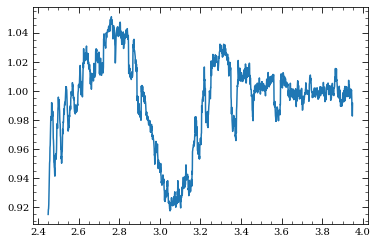

In [67]:
plt.plot(w, spec_norm)

In [68]:
# Fit water ice and NVR thicknesses (um)
deg_arr = np.array([1,2,3])#,4,5])
chi_arr = []
for deg in deg_arr:

    cf = jl_poly_fit(w[ind_fit], spec_fin[ind_fit], deg=deg, robust_fit=True)
    spec_cont = jl_poly(w, cf)
    spec_norm = spec_fin / spec_cont
    
    pinit = [0.001,0.001]
    ifit = (w>2.8) & (w<3.7)

    wfit = wind[ifit]
    sfit = spec_norm[ifit]
    pfit, perr, pfit_all = fit_bootstrap(pinit, wfit, sfit, abs_func, nrand=100, 
                                         yerr_systematic=yerr_sys, return_more=True)
    
    model = abs_func(wfit, pfit)
    chi = np.sum((sfit - model)**2 / model)
    chi_arr.append(chi)
    
    print(deg, chi, pfit)
    
chi_arr = np.array(chi_arr)

1 0.35021747549061766 [0.01523758 0.04699968]
2 0.21747948819779772 [0.00244346 0.19575093]
3 0.08053010888681483 [0.02080122 0.13088127]


In [71]:
# Fit water ice and NVR thicknesses (um)

# Choose degree of polynomial that provides the best fit
# if do_flat:
#     deg = 1
# else:
deg = deg_arr[chi_arr==np.min(chi_arr)][0]
deg = 3

cf = jl_poly_fit(w[ind_fit], spec_fin[ind_fit], deg=deg, robust_fit=True)
spec_cont = jl_poly(w, cf)
spec_norm = spec_fin / spec_cont

pinit = [0.001,0.001]
ifit = (w>2.8) & (w<3.6)

wfit = w[ifit]
sfit = spec_norm[ifit]
pfit, perr, pfit_all = fit_bootstrap(pinit, wfit, sfit, abs_func, nrand=100, 
                                     yerr_systematic=yerr_sys, return_more=True)


In [72]:
print(f"Modeled Ice Layer = {ice_thick:4.0f} A")
print(f"Modeled NVR Layer = {nvr_thick:4.0f} A")
print("")
print("Ice Layer = {:4.0f} +/- {:3.0f} A".format(pfit[0]*1e4, perr[0]*1e4))
print("NVR Layer = {:4.0f} +/- {:3.0f} A".format(pfit[1]*1e4, perr[1]*1e4))

Modeled Ice Layer =  316 A
Modeled NVR Layer =  945 A

Ice Layer =  218 +/-  46 A
NVR Layer = 1291 +/- 116 A


In [73]:
# Compare model EW to data
model = abs_func(wind, pfit)

print("EW Total      EW(2.6-3.3)   EW(3.3-3.8)")

# Model
ew_nom = extract_ew(wind, model)
print(ew_nom)

# Data
ew_nom = extract_ew(wind, spec_norm)
print(ew_nom)

EW Total      EW(2.6-3.3)   EW(3.3-3.8)
[418.85914602 342.46934614  76.38979988]
[430.64945723 338.75060164  91.89885559]


In [74]:
# Randomize throughput curve
nrand = 1000

t = wave_extract - wave_extract.min()
t /= t.max()
t = t + np.random.random_sample(size=nrand).reshape([-1,1])
t = t * (2*np.pi) * 10*np.random.random_sample(size=nrand).reshape([-1,1])
ns = np.random.normal(loc=1, scale=0.05, size=nrand).reshape([-1,1]) + \
     np.random.normal(loc=0.03, scale=0.005, size=nrand).reshape([-1,1]) * \
     np.sin(t)

th_new = bp_val * ns

# Normalize extracted spectrum by spectral template and throughput curve
norm_val_all = sp_val * th_new
norm_val_conv_all = np.array([convolve(val, g) for val in norm_val_all])
spec_corr_all = spec_extract / norm_val_conv_all

# Cut off edges and normalize at continuum location
ind = (wave_extract>2.45) & (wave_extract<3.95)
wind = wave_extract[ind]
spec_fin_all = spec_corr_all[:,ind]
spec_fin_all = spec_fin_all / np.median(spec_fin_all[:,wind<2.8], axis=1).reshape([-1,1])

# Fit continuum as first guess
deg=3
ind_fit = ((w>=2.5) & (w<=2.7)) | ((w>=3.8) & (w<=3.95))
# ind_fit = ((wind>=2.6) & (wind<=2.75)) | ((wind>=3.8) & (wind<=3.95))
cf_all = jl_poly_fit(wind[ind_fit], spec_fin_all[:,ind_fit].transpose(), deg=deg, robust_fit=True)

# Better fitting function
cf_cont_all = []
cf_abs_all = []
for i in trange(nrand):
    pinit = list(cf_all[:,i]) + [0.001, 0.001]
    res = fit_bootstrap(pinit, wind, spec_fin_all[i], cont_abs_func, nrand=0)
    cf_cont_all.append(res[:-2])
    cf_abs_all.append(res[-2:])
cf_cont_all = np.array(cf_cont_all)
cf_abs_all = np.array(cf_abs_all)

# Remove continuum
cont_all = jl_poly(wind, cf_cont_all.transpose(), dim_reorder=True)
spec_norm_all = spec_fin_all / cont_all

# Absorption models
abs_model_all = np.array([abs_func(wind, pfit) for pfit in cf_abs_all])

  0%|          | 0/1000 [00:00<?, ?it/s]

EW Total      EW(2.6-3.3)   EW(3.3-3.8)
[401.13046617 336.41646769  64.62407649]
[76.80539237 60.81655153 32.12127864]


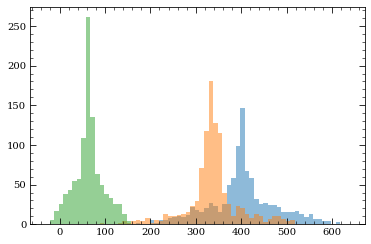

In [75]:
ew_all = np.array([extract_ew(wind, val) for val in spec_norm_all])
ew_med = np.median(ew_all, axis=0)
ew_std = np.std(ew_all, axis=0)

print("EW Total      EW(2.6-3.3)   EW(3.3-3.8)")
print(np.median(ew_all, axis=0))
print(np.std(ew_all, axis=0))

bins = np.arange(np.min(ew_all), np.max(ew_all), 10)
_ = plt.hist(ew_all[:,0], bins=bins, alpha=0.5)
_ = plt.hist(ew_all[:,1], bins=bins, alpha=0.5)
_ = plt.hist(ew_all[:,2], bins=bins, alpha=0.5)

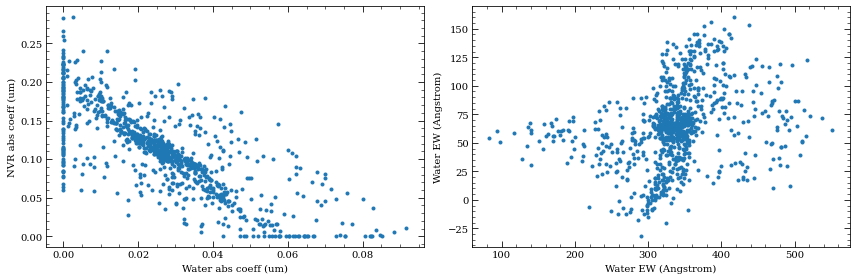

In [76]:
# Plot covariance between parameter fits
fig, axes = plt.subplots(1,2, figsize=(12,4))

ax = axes[0]
x, y = cf_abs_all[:,0], cf_abs_all[:,1]
ax.plot(x, y, marker='.', ls='none')
ax.set_xlabel('Water abs coeff (um)')
ax.set_ylabel('NVR abs coeff (um)')

ax = axes[1]
x, y = ew_all[:,1], ew_all[:,2]
ax.plot(x, y, marker='.', ls='none')
ax.set_xlabel('Water EW (Angstrom)')
ax.set_ylabel('Water EW (Angstrom)')

fig.tight_layout()

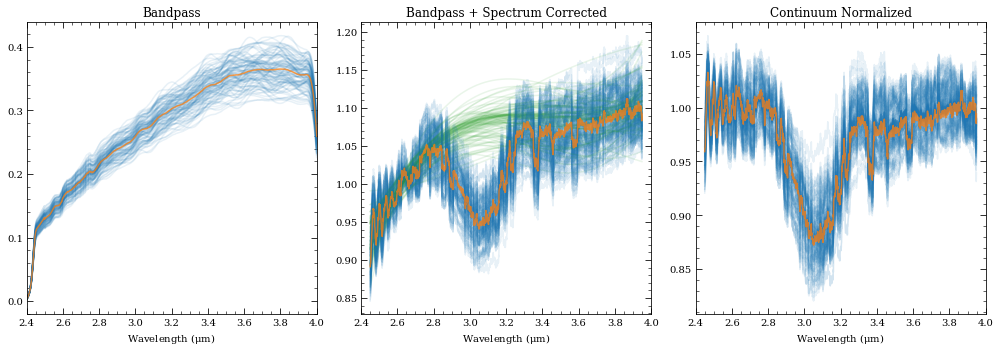

In [77]:
fig, axes = plt.subplots(1,3, figsize=(14,5))

for val in th_new[0:100]:
    axes[0].plot(wave_extract, val, alpha=0.1, color='C0')

for i, val in enumerate(spec_fin_all[0:100]):
    axes[1].plot(wind, val, alpha=0.1, color='C0', rasterized=True)
    axes[1].plot(wind, cont_all[i,:], alpha=0.1, color='C2')
    
for val in spec_norm_all[0:100]:
    axes[2].plot(wind, val, alpha=0.1, color='C0', rasterized=True)

    
axes[0].plot(bp.wave/1e4, bp.throughput, color='C1', alpha=0.75)
axes[1].plot(wind, spec_fin, color='C1', alpha=0.75)
axes[2].plot(wind, spec_norm, color='C1', alpha=0.75)

for ax in axes:
    ax.set_xlabel(f'Wavelength ({str_um})')
    ax.set_xlim([2.4,4.0])
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])
    
axes[0].set_title("Bandpass")
axes[1].set_title("Bandpass + Spectrum Corrected")
axes[2].set_title("Continuum Normalized")

fig.tight_layout()
# fig.savefig(figdir+'error_spectra.pdf')
# fig.savefig(figdir+'error_spectra.png')

In [78]:
def plot_overview(save_fig=True):
    fig, axes = plt.subplots(1,3, figsize=(14,4))

    
    str_um = '$\mathdefault{\mu m}$'
    str_ang = '$\mathdefault{\AA}$'

    
    ax = axes[0]
    ax.plot(wave_extract, spec_extract, label='Raw Spectrum')
    ax.set_title('Extracted Spectrum')
    ax.set_ylabel('Counts/sec')

    ax2 = axes[0].twinx()
    ax2.plot(wave_extract, sp_val/sp_val.max(), color='C2', label=f'{spt} Spectrum')
    ax2.plot(bp.wave/1e4, bp.throughput, color='C3', label = 'Bandpass')
    #ax2.set_ylabel('Throughput')

    ax.set_ylim(ax.get_ylim()[0], 12000)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')


    ax = axes[1]
    ax.plot(wind, spec_fin, label='Corrected Spectrum')
    ax.plot(wind[ind_fit], spec_fin[ind_fit], marker='.', ls='none', label='Fit Data')
    ax.plot(wind, spec_cont, label='Polynomial Fit')
    ax.set_title('Continuum Fit')
    ax.set_ylabel('Normalized Counts')
    ax.legend()

    #################################
    # Normalized spectrum and model fits
    ax = axes[2]
    ax.plot(wind, spec_norm, label='Normalized Spectrum')
    ylim2 = [0.70, 1.05]
    
    ax.set_title('Absorption Spectrum')
    ax.set_ylabel('Normalized Transmission')

    label = f'Water = {pfit[0]*1e4:4.0f} $\pm$ {perr[0]*1e4:3.0f} {str_ang}'
    ax.plot(wind, abs_func(wind, [pfit[0], 0]), label=label)
    label = f'NVR   = {pfit[1]*1e4:4.0f} $\pm$ {perr[1]*1e4:3.0f} {str_ang}'
    ax.plot(wind, abs_func(wind, [0, pfit[1]]), label=label)
    ax.plot(wind, abs_func(wind, pfit), label='Total Absorption')
    #ax.plot(wind, abs_func2(wind, pfit2))
    ax.set_ylim([ax.get_ylim()[0],1.05])
    ax.legend(loc='lower right')

    # Equivalent widths
    for xv in [2.6,3.3,3.8]:
        ax.plot([xv,xv], ylim2, ls='--', lw=1, color='k')

    txt_vals = f' {ew_med[0]:.0f} $\pm$ {ew_std[0]:.0f} {str_ang}' 
    ax.text(2.65, 0.84, 'EW$_\mathrm{tot}$ =\n ' + txt_vals)
    txt_vals = f' {ew_med[1]:.0f} $\pm$ {ew_std[1]:.0f} {str_ang}' 
    ax.text(2.65, 0.73, 'EW$_{2.6-3.3}$ =\n ' + txt_vals)
    txt_vals = f' {ew_med[2]:.0f} $\pm$ {ew_std[2]:.0f} {str_ang}' 
    ax.text(3.4, 0.84, 'EW$_{3.3-3.8}$ =\n ' + txt_vals)


    for ax in axes:
        ax.set_xlabel(f'Wavelength ({str_um})')
        ax.set_xlim([2.4,4.1])
        ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])

    axes[2].set_xlim([2.5,3.9])
    axes[2].set_ylim(ylim2)

    title = f"Modeled Ice Layer = {ice_thick:.0f} {str_ang}; NVR Layer = {nvr_thick:.0f} {str_ang}"
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

    if save_fig:
        save_name = f'fit_bpspcorr_ice{ice_thick:04.0f}_nvr{nvr_thick:04.0f}.pdf'
        do_flat = do_flat_on_slopes or do_flat_on_diff
        if not do_flat:
            save_name = save_name[:-4] + '_noflatcorr.pdf'
            
        save_path = os.path.join(figdir, save_name)
        fig.savefig(save_path)
        print(f'Saved to: {save_path}')
        

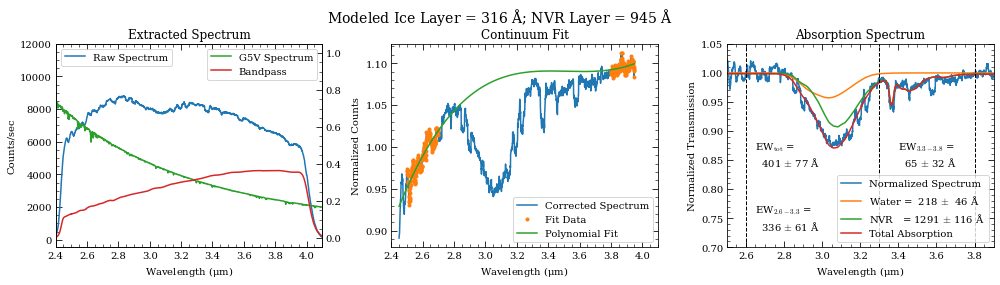

In [79]:
plot_overview(save_fig=False)

Saved to: /Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC35/figures_20220105/fit_bpspcorr_ice0316_nvr0945.pdf


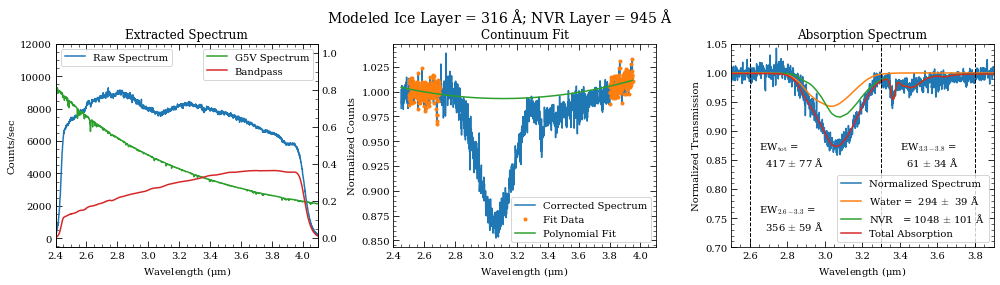

In [49]:
plot_overview(save_fig=True)